In [1]:
# importing modules to use
import numpy as np

import pandas as pd

import os

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import signal
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
from scipy.stats import cauchy
from scipy.special import legendre

In [2]:
#Droplet Oscillation Fast Fourier Transform Analysis
import DOFFTA

In [6]:
filepath = input('File location: ')

#file location
dir_path = os.path.dirname(filepath)
print( dir_path)

#/Users/danhardy/OneDrive - University of Bristol/BARC Desktop/Python Porjects/Droplet Oscilations/aspect ratio.txt


File location:  /Users/danhardy/OneDrive - University of Bristol/BARC Desktop/Python Porjects/Droplet Oscilations/DOFFTA/example aspect ratio.txt


/Users/danhardy/OneDrive - University of Bristol/BARC Desktop/Python Porjects/Droplet Oscilations/DOFFTA


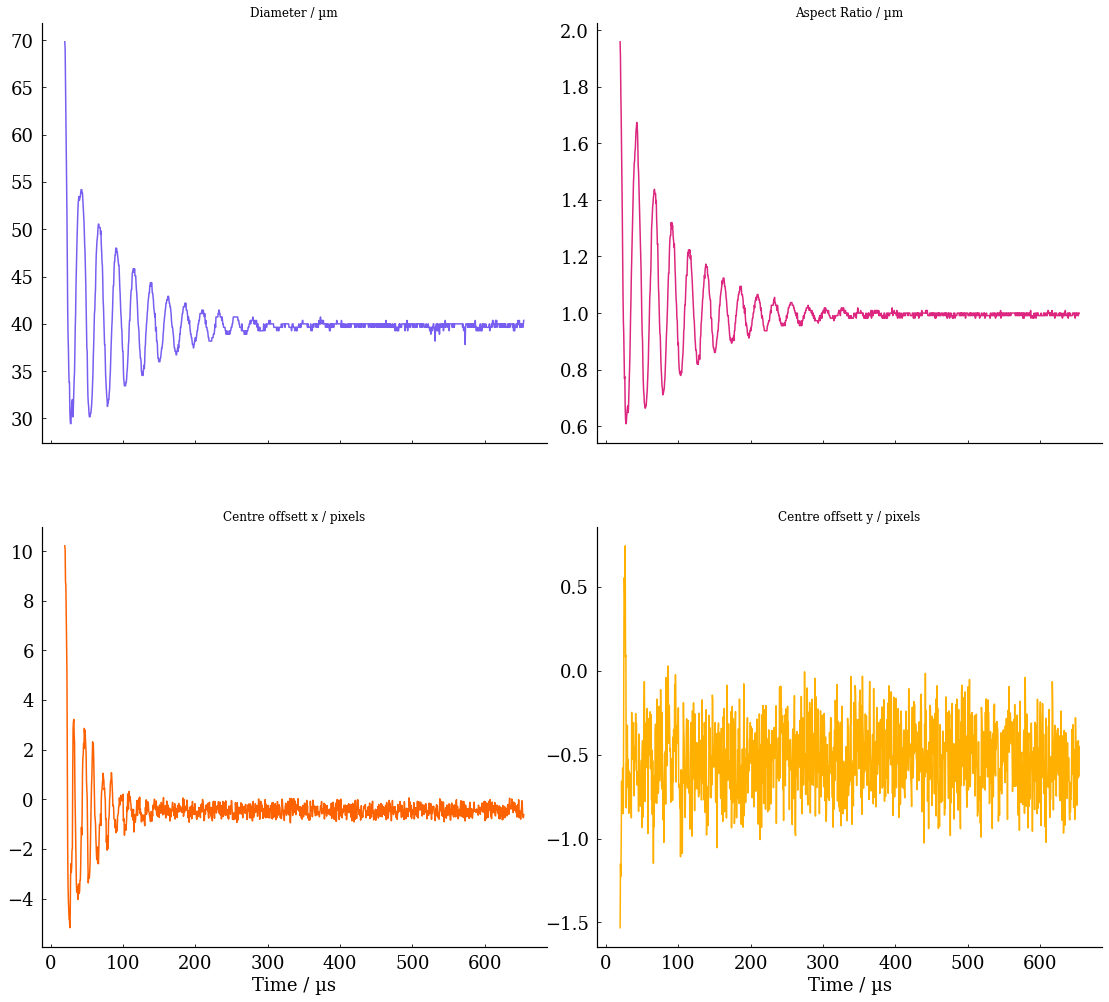

In [7]:
experimental_data = DOFFTA.import_data(filepath)
DOFFTA.review_data(experimental_data)

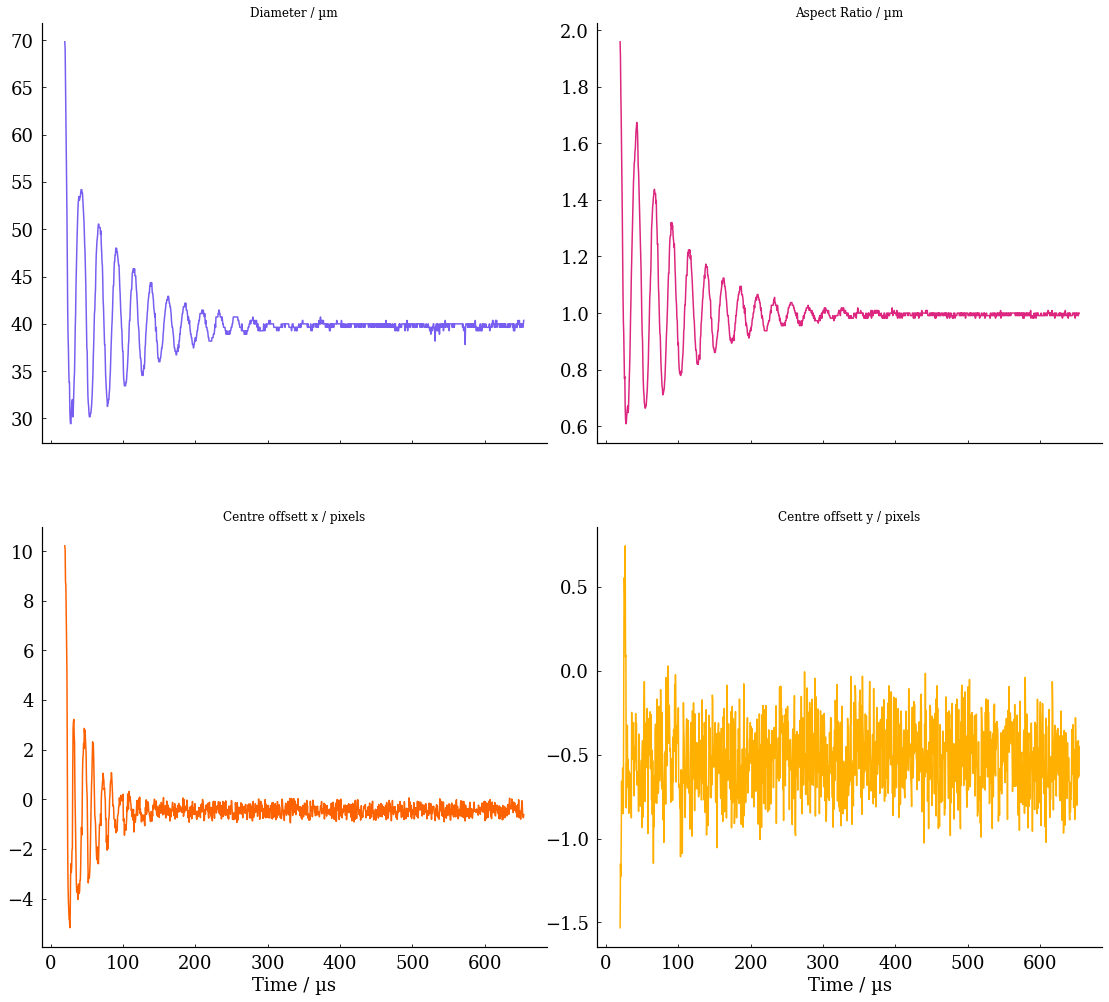

In [8]:
experimental_data = DOFFTA.remove_unecessary_data(experimental_data)
DOFFTA.review_data(experimental_data)

In [9]:
d_final, AR_final, d_correction, d_calibrated, A_0_estimate = DOFFTA.get_calibrated_diameter(experimental_data)

In [10]:
calibrated_data = DOFFTA.get_calibrated_data(experimental_data, d_correction)

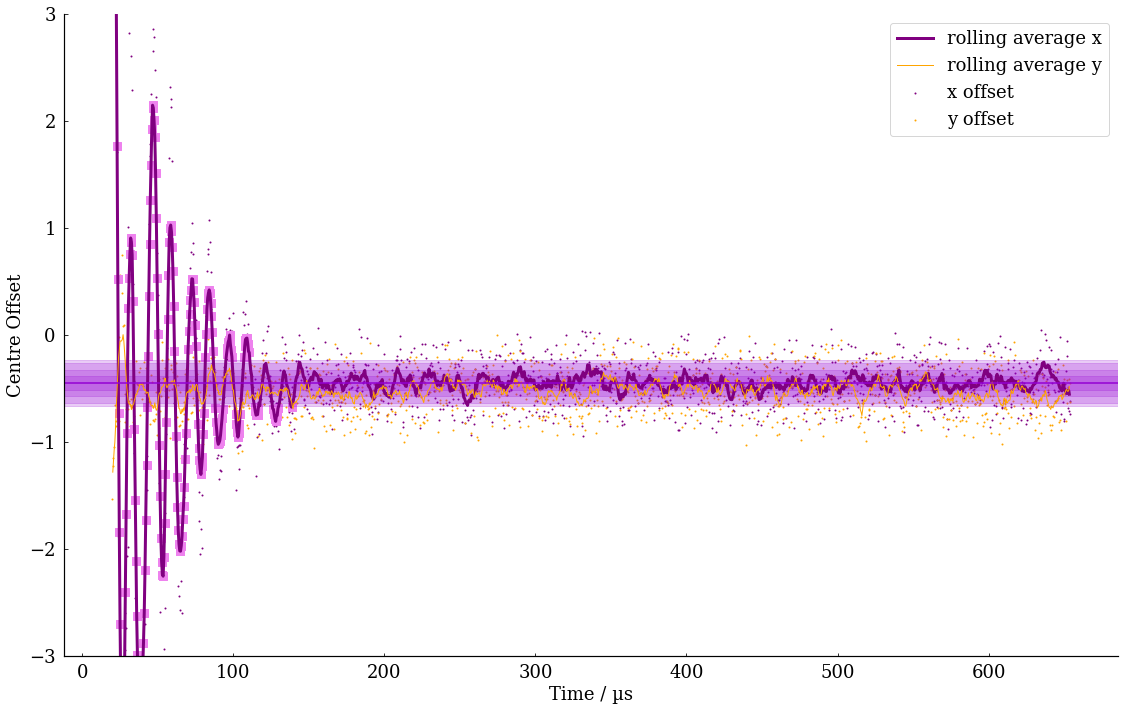

Calculated cut off (µs): 138.61
Is this cut off sensible? 

If yes, press enter. 

If no, enter a suggested value below (in µs):


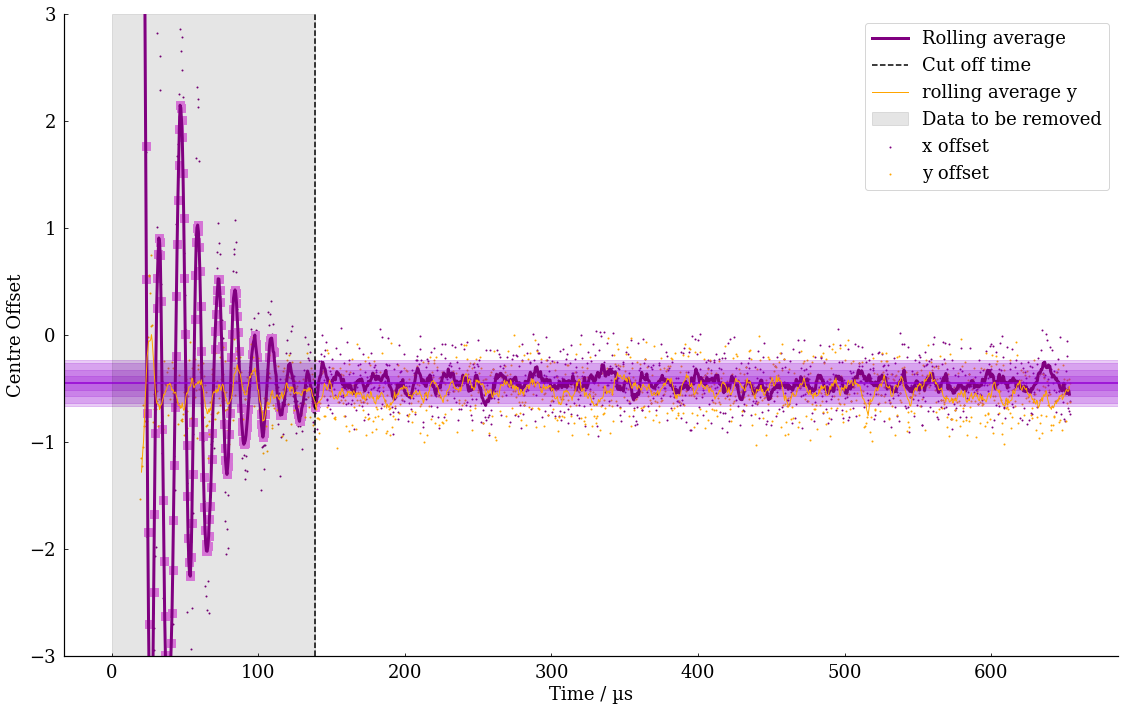

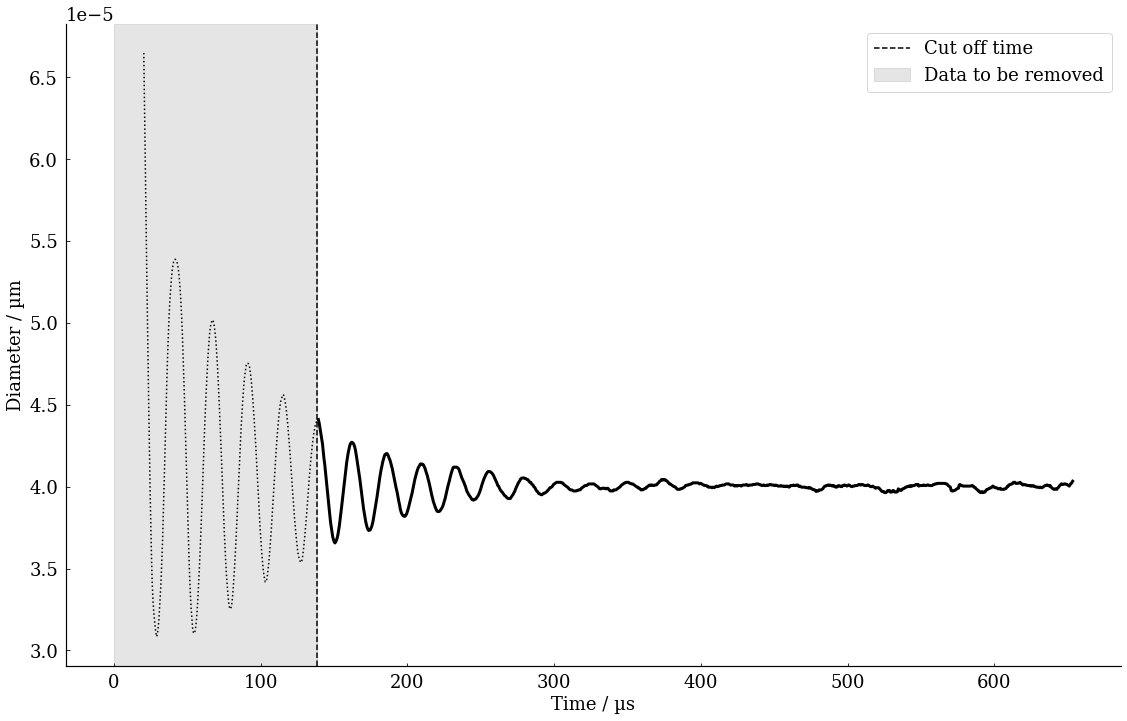

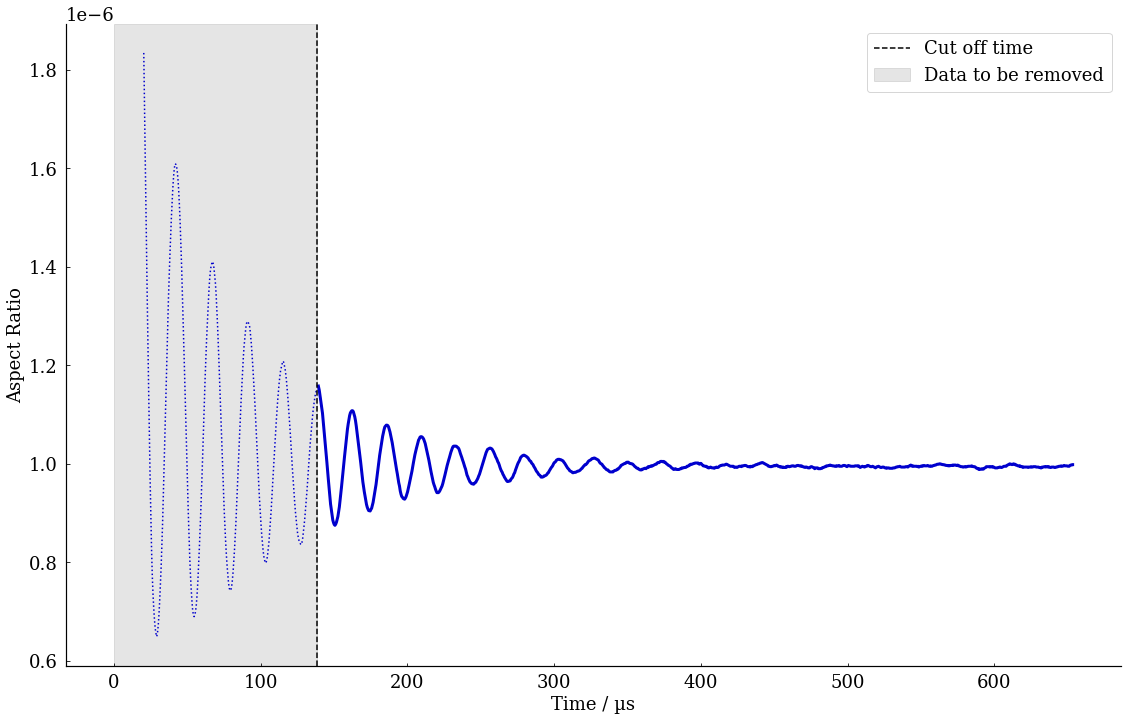

In [13]:
trimmed_data = DOFFTA.review_centre_offset(calibrated_data, save_figures='y', save_location= dir_path)

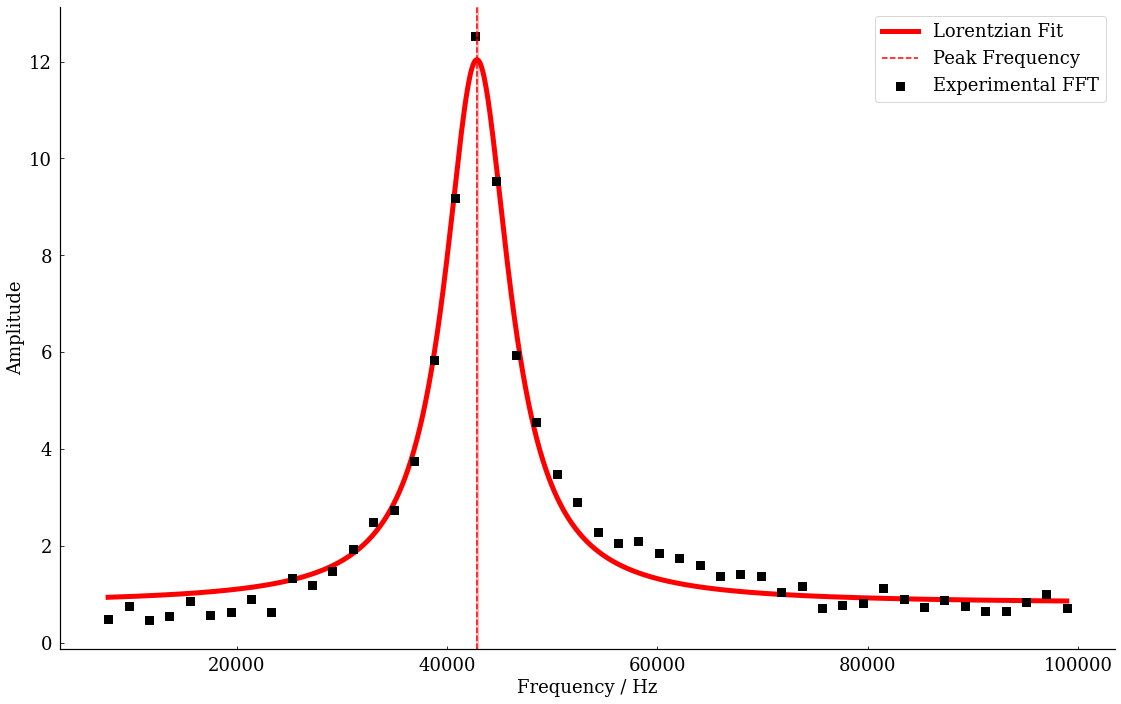

Surface tension / mN/m:
73.04 ± 0.326


In [22]:
sigma, sigma_error, lorenzian_fit_data, experimental_fft = DOFFTA.full_surface_tension_calculation(trimmed_data.time_s, trimmed_data.aspect_ratio.values, d_calibrated/2, density = 1004,
                                        save_figures = 'y', save_location = dir_path)
print("Surface tension / mN/m:\n" + str(round(sigma*1e3,3)) + ' ± ' + str(round(sigma_error*1e3,3)))

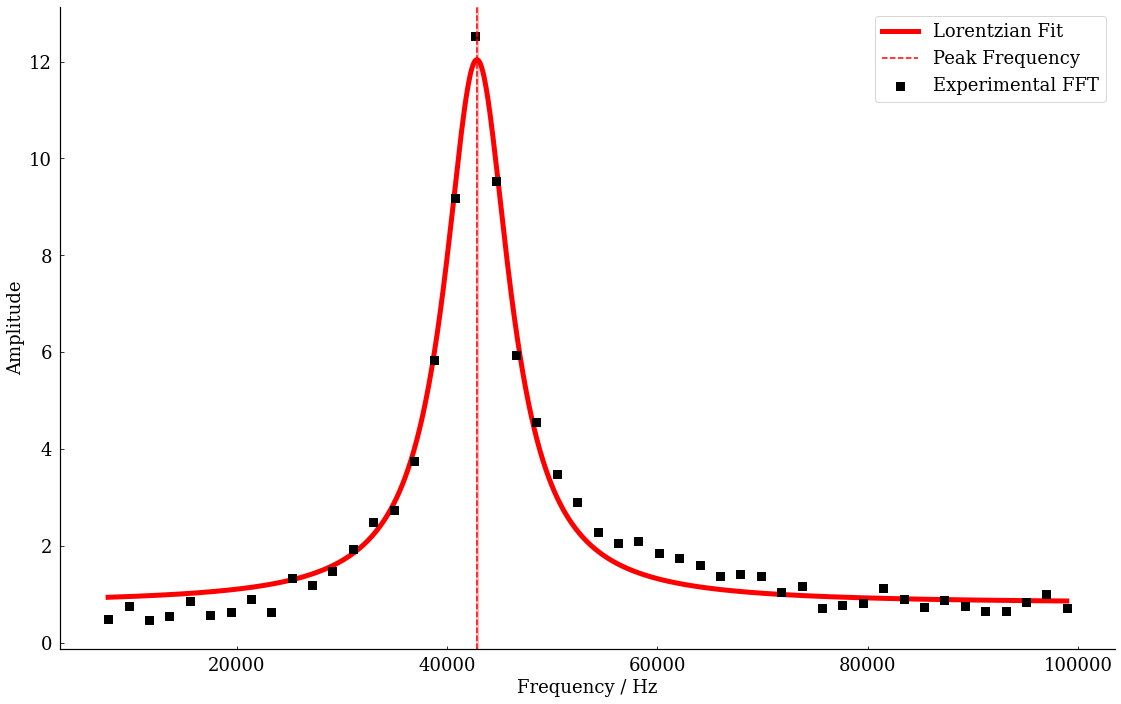

In [15]:
DOFFTA.save_experiment_parameters(dir_path,calibrated_data, trimmed_data)

In [16]:
print('Observed Diameter / µm: \t' + str(d_final/1e-6))
print('Blur Corrected Diameter / µm: \t' + str(d_calibrated/1e-6))
print('Expected Diameter / µm: \t' + str(2*DOFFTA.get_water_true_diameter(sigma,d_calibrated/2)/1e-6))

Observed Diameter / µm: 	39.854544399999995
Blur Corrected Diameter / µm: 	40.05755492669942
Expected Diameter / µm: 	40.09062278799312
